# Libraries

In [1]:
import cv2
import pandas as pd
from ultralytics import YOLO
import supervision as sv
import matplotlib.pyplot as plt
from tracker import*
from warnings import filterwarnings
filterwarnings('ignore')

# Read The Input Video File

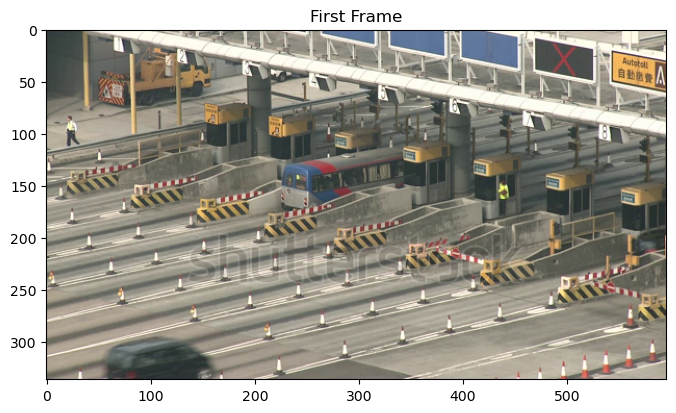

In [2]:
video = 'toll_gate.mp4'
cap = cv2.VideoCapture(video)

ret, frame = cap.read()
cap.release()
frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(8, 6))
plt.imshow(frame_rgb)
plt.title('First Frame')  
plt.show()


# Vehicle Counter

In [3]:
tracker=Tracker()
model=YOLO('yolov10x.pt')

class_list = ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']

In [4]:
count=0
cap = cv2.VideoCapture(video)

START = (0, 155)
END = (550, 290)
line_slope = (END[1] - START[1]) / (END[0] - START[0])
line_intercept = START[1] - line_slope * START[0]

counter = {}
counter_car = set()
counter_bus = set()

fps = cap.get(cv2.CAP_PROP_FPS)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))


fourcc = cv2.VideoWriter_fourcc(*'mp4v') 
out = cv2.VideoWriter('result.mp4', fourcc, fps, (width, height))

while True:
    ret, frame = cap.read()
    if not ret:
        break

    results = model.predict(frame)
    a = results[0].boxes.data
    a = a.detach().cpu().numpy()
    px = pd.DataFrame(a).astype("float")

    list_car = []
    list_bus = []

    for index, row in px.iterrows():
        x1 = int(row[0])
        y1 = int(row[1])
        x2 = int(row[2])
        y2 = int(row[3])
        d = int(row[5])
        c = class_list[d]

        if 'car' in c:
            list_car.append([x1, y1, x2, y2])
        elif 'bus' in c:
            list_bus.append([x1, y1, x2, y2])

    bbox_id_car = tracker.update(list_car)
    for bbox in bbox_id_car:
        x3, y3, x4, y4, id = bbox
        cx = int((x3 + x4) // 2)
        cy = int((y3 + y4) // 2)
        cv2.putText(frame, 'car', (x3, y3 - 10), cv2.FONT_HERSHEY_COMPLEX, 0.5, (255, 255, 255), 2)
        cv2.circle(frame, (cx, cy), 4, (0, 0, 255), -1)  
        cv2.rectangle(frame, (x3, y3), (x4, y4), (0, 255, 0), 2)  
        cv2.putText(frame, str(id), (cx, cy), cv2.FONT_HERSHEY_COMPLEX, 0.8, (0, 255, 255), 2)

        y_line = line_slope * cx + line_intercept
        offset = 2

        if (START[0] < cx < END[0] and abs(cy - y_line) < offset): 
            if id not in counter:  
                counter[id] = cy
                counter_car.add(id)
                cv2.circle(frame, (cx, cy), 4, (0, 0, 255), -1)
                cv2.putText(frame, str(id), (cx, cy), cv2.FONT_HERSHEY_COMPLEX, 0.8, (0, 255, 255), 2)

    bbox_id_bus = tracker.update(list_bus)
    for bbox in bbox_id_bus:
        x3, y3, x4, y4, id = bbox
        cx = int((x3 + x4) // 2)
        cy = int((y3 + y4) // 2)
        cv2.putText(frame, 'bus', (x3, y3 - 10), cv2.FONT_HERSHEY_COMPLEX, 0.5, (255, 255, 255), 2)
        cv2.circle(frame, (cx, cy), 4, (255, 0, 0), -1)  
        cv2.rectangle(frame, (x3, y3), (x4, y4), (255, 0, 0), 2)  
        cv2.putText(frame, str(id), (cx, cy), cv2.FONT_HERSHEY_COMPLEX, 0.8, (0, 255, 255), 2)

        y_line = line_slope * cx + line_intercept
        offset = 4
        if (START[0] < cx < END[0] and abs(cy - y_line) < offset): 
            if id not in counter:
                counter[id] = cy
                counter_bus.add(id)
                cv2.circle(frame, (cx, cy), 4, (255, 0, 0), -1)
                cv2.putText(frame, str(id), (cx, cy), cv2.FONT_HERSHEY_COMPLEX, 0.8, (0, 255, 255), 2)

    text_color = (255, 255, 255) 
    red_color = (0, 0, 255) 

    cv2.line(frame, START, END, red_color, 3)  

    cars = len(counter_car)
    buses = len(counter_bus)

    cv2.putText(frame, 'cars - ' + str(cars), (30, 40), cv2.FONT_HERSHEY_COMPLEX, 1, red_color, 1, cv2.LINE_AA)
    cv2.putText(frame, 'buses - ' + str(buses), (30, 60), cv2.FONT_HERSHEY_COMPLEX, 1, red_color, 1, cv2.LINE_AA)

    out.write(frame)

    cv2.imshow("frames", frame)
    if cv2.waitKey(1) & 0xFF == 27:
        break

cap.release()
out.release()  
cv2.destroyAllWindows()



0: 384x640 1 person, 1 car, 1 bus, 1 traffic light, 158.1ms
Speed: 20.7ms preprocess, 158.1ms inference, 106.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 car, 1 bus, 1 traffic light, 106.5ms
Speed: 5.6ms preprocess, 106.5ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 car, 1 bus, 1 traffic light, 74.8ms
Speed: 6.9ms preprocess, 74.8ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 car, 1 bus, 1 traffic light, 69.5ms
Speed: 3.2ms preprocess, 69.5ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 car, 1 bus, 80.0ms
Speed: 3.4ms preprocess, 80.0ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 car, 1 bus, 73.6ms
Speed: 4.5ms preprocess, 73.6ms inference, 8.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 car, 1 bus, 69.7ms
Speed: 3.6ms preprocess, 69.7ms inference,